# **Dog Breed Identification App**
## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App
---

This project aims at developing an algorithm that could be used as part of a mobile or web app. At the end of the project, our code will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed that is most resembling. If a human image is supplied, the code will identify the resembling dog breed.

![Sample Dog Output](images/sample_dog_output.png)

### Step 0: Import Datasets

#### Import Dog Dataset

We'll import a dataset of dog images. We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing files paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels
- `dog_names` - list of string-valued dog breed names for translating labels

In [48]:
from sklearn.datasets import load_files
from keras.utils import to_categorical
import numpy as np
from glob import glob

# define a function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# Load train, test and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# Load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# Define the file path to save the dog names
file_path = "dog_names.txt"

# Open the file in write mode and save the dog names
with open(file_path, "w") as f:
    for name in dog_names:
        f.write(name + "\n")
        
num_dog_breeds = len(dog_names)

img_width = 224
img_height = 224
img_channels = 3

# print statistics about the dataset
print('There are %d total dog categories.' % num_dog_breeds)
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


#### Import Human Dataset

We'll import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset0
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---

### Step 1: Detect Humans

We'll use OpenCV's implementation of [Haar feature-based cascade classifiers](https://docs.opencv.org/3.4/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images. OpenCV provides many pre-trained face detectors stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades). We have downloaded one of these detectors and stored it in the `haarcascades` directory.

We'll use this detector to find human faces in a sample image.

Number of faces detected: 1


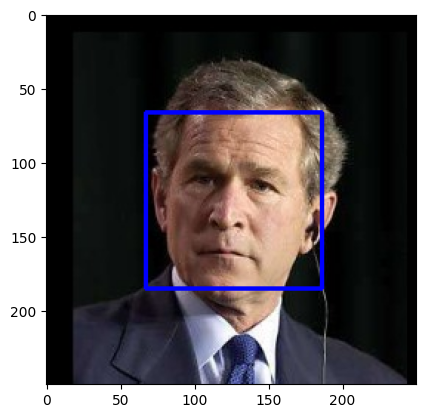

In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[5])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x, y, w, h) in faces:
    # add bounding box to color image
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show() 

Before using any of the face detectors, it is a standard procedure to convert the images to grayscale.The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face. Each detected face is a 1D array with four entries that specifies the bounding box of the detected face. The first two entries in the array (extracted as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box. The last two entries in the array (extracted as `w` and `h`) specify the width and height of the box.

#### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise. This function, aptly named `face_detector`, takes a string-valued file path to an image as input.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0 

#### Assess the Human Face Dectector

**Question 1:** Test the performance of the `face_detector` function.
- What percentage of the first 100 images in `human_files` have a detected human face?
- What percentage of the first 100 images in `dog_files` have a detected human face?

Ideally, there should be 100% of human images with a detected face and 0% of dog images with a detected face. We'll extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

**Answer:**
1. Percentage of human_files with a detected human face is: 99.0%
2. Percentage of dog_files with a detected human face is: 12.0%

Although the results are not perfect but our algorithm gives acceptable performance.

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Test the performance of the face_detector algorithm
# on the images in human_files_short and dog_files_short
def count_images_with_faces(images):
    count = 0
    image_names = []

    for image in images:
        if face_detector(image):
            count += 1
            image_names.append(image)

    return count, np.array(image_names)

face_count_human_files, human_files_with_faces = count_images_with_faces(human_files_short)
face_count_dog_files, dog_files_with_faces = count_images_with_faces(dog_files_short)

print('Percentage of human_files with a detected human face is: ' + str(face_count_human_files/100 * 100) + '%')
print('Percentage of dog_files with a detected human face is: ' + str(face_count_dog_files/100 * 100) + '%')

Percentage of human_files with a detected human face is: 99.0%
Percentage of dog_files with a detected human face is: 12.0%


**Question 2:** This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unnecessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

**Answer:**
I don't think that this is a reasonable expectation to pose on the user to only provide a clear view of a face because this is not possible in the real world. To detect humans in images, we can use an algorithm which detects other features such as hair and body along with the face to make sure that a human is being detected.

---

### Step 2: Detect Dogs

We'll use a pre-trained [ResNet - 50](https://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images. Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](https://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model_dog = ResNet50(weights='imagenet')

#### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

<p style="text-align: center;">(nb_samples, rows, columns, channels),</p>

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is 224 x 224 pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

<p style="text_align: center;">(1, 224, 224, 3).</p>

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape

<p style="text_align: center;">(nb_samples, 224, 224, 3).</p>

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths. It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [10]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

#### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing. First, the RGB image is converted to BGR by reordering the channels. All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as [103.939, 116.779, 123.68] and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image. This is implemented in the imported function `preprocess_input` ([preprocess_input](https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py)).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions. This is accomplished with the `predict` method, which returns an array whose i-th entry is the model's predicted probability that the image belongs to the i-th ImageNet category. This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns rprediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model_dog.predict(img))

#### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`. Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need to only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
# returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <=268) & (prediction >= 151))

#### Assess the Dog Detector

**Question 3:** Test the performance of the `dog_detector` function.
- What percentage of the images in `human_files_short` have a detected dog?
- What percentage of the images in `dog_files_short` have a detected dog?

**Answer:**
1. Percentage of human files with a detected dog is 0.0%
2. Percentage of dog files with a detected dog is 100.0%

In [13]:
# Test the performance of the dog_detector function
# on the images in human_files_short and dog_files_short.

def count_images_with_dogs(images):
    count = 0
    image_names = []

    for image in images:
        if dog_detector(image):
            count += 1
            image_names.append(image)

    return count, image_names

dog_count_human_files, human_files_with_dogs = count_images_with_dogs(human_files_short)
dog_count_dog_files, dog_files_with_dogs = count_images_with_dogs(dog_files_short)

print('Percentage of human files with a detected dog is ' + str(dog_count_human_files / 100 * 100) + '%')
print('Percentage of dog files with a detected dog is ' + str(dog_count_dog_files / 100 * 100) + '%')

1/1 [==============================] - 0s 191ms/step
Percentage of human files with a detected dog is 0.0%
Percentage of dog files with a detected dog is 100.0%


---

### Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. In this step, we'll create a CNN that classifies dog breeds. We need to create or CNN from scratch (so, we can't use transfer learning yet!), and we must attain a test accuracy of at least 1%. 

We need to be careful with adding too many trainable layers! More parameters means longer training, which means we are more likely to need a GPU to accelerate the training process. Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take;an extrapolate this estimate to figure out how long it will take for our algorithm to train.

The task of assigning breed to dogs from images is considered exceptionally challenging. To see why, consider that even a human would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.

Brittany | Welsh Springer Spaniel
-|-
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).

Curly-Coated Retriever | American Water Spaniel
-|-
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

Likewise, recall that labradors come in yellow, chocolate, and black. Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.

Yellow Labrador | Chocolate Labrador | Black Labrador
-|-|-
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.

Practice is far ahead of the theory in dep learning. So we need to experiment with many different architectures, and trust our intuition. And, of course, have fun!

#### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255. 

In [23]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 159.46it/s]


#### Model Architecture

We'll create a CNN to classify dog breed.

Here's a model that trains relatively fast on CPU and attains > 1% test accuracy in 5 epochs.

![Sample CNN](images/sample_cnn.png)

**Question 4:** Outline the steps you took to get to your final CNN architecture and your reasoning at each step. If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

**Answer:**

Here are the steps for my final CNN architecture:
1. Initialize a sequential model. Sequential models provide a covenient and effective way to define the architecture of the network. It is flexible and allows to add different layers into the model in an organized and sequential manner.
2. Add a BatchNormalization layer as the first layer of the model. It helps to make the training more stable and faster.
3. Add a Convolutional layer with 64 filters, a kernel size of 3x3 and ReLU activation function. Convolutional layer helps in learning spatial hierarchies in the data, capturing patterns and features from the input images.
4. Add a MaxPooling2D layer with a pool size of 2x2. Max pooling reduces the spatial dimensions of the feature maps, focusing on the most important features and reducing computational complexity.
5. Repeat batch normalization, convolution, and max pooling with increased number of filters, 128 athen 256 to help the model learn hierarchical features of increasing complexity.
6. Add a Dropout layer with a dropout rate of 20%. It is a regularization technique to prevent overfitting.
7. Add a GlobalAveragePooling2D layer to reduce the number of parameters in the model and improve generalization.
8. Flatten the output into a one dimensional vector to prepare it for the final classification layer.
9. Add a Dense (fully connected) layer with 133 classes and softmax activation function. Softmax gives the probability distribution over classes.

CNN architechture should work well for the image classification task because of its ability to automatically learn hierarchical features in images. 

In [17]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras import backend as K
from keras.layers import BatchNormalization

In [40]:
num_dog_breeds = len(dog_names)

K.clear_session()
model = Sequential()

# Define the architecture
model.add(BatchNormalization(input_shape=(img_width, img_height, img_channels)))
model.add(Conv2D(filters=64, kernel_size=3, activation="relu")) # Add a 2D Convolutional layer
model.add(MaxPooling2D(pool_size=2)) # Add Max Pooling layer
        
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=3, activation="relu")) # Add a 2D Convolutional layer
model.add(MaxPooling2D(pool_size=2)) # Add a Max Pooling layer

model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=3, activation="relu")) # Add a 2D Convolutional layer
model.add(MaxPooling2D(pool_size=2)) # Add a Max Pooling layer

model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D()) # Add a GAP layer
model.add(Flatten())

model.add(Dense(133, activation="softmax")) # Add a Dense layer

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 224, 224, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 111, 111, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                        

#### Compile the Model

In [41]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Train the Model

We'll train the model and use model checkpointing to save the model that attains the best validation loss. We can also [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [42]:
from keras.callbacks import ModelCheckpoint

# specify the number of epochs that you would use to train the model

epochs = 5

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',
                               verbose=1, save_best_only=True)

In [43]:
model.fit(train_tensors, train_targets,
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/5
334/334 [==============================] - ETA: 0s - loss: 5.0001 - accuracy: 0.0187
Epoch 1: val_loss improved from inf to 4.86070, saving model to saved_models\weights.best.from_scratch.hdf5
334/334 [==============================] - 642s 2s/step - loss: 5.0001 - accuracy: 0.0187 - val_loss: 4.8607 - val_accuracy: 0.0204
Epoch 2/5
334/334 [==============================] - ETA: 0s - loss: 4.6175 - accuracy: 0.0400
Epoch 2: val_loss improved from 4.86070 to 4.56767, saving model to saved_models\weights.best.from_scratch.hdf5
334/334 [==============================] - 665s 2s/step - loss: 4.6175 - accuracy: 0.0400 - val_loss: 4.5677 - val_accuracy: 0.0383
Epoch 3/5
334/334 [==============================] - ETA: 0s - loss: 4.3359 - accuracy: 0.0696
Epoch 3: val_loss improved from 4.56767 to 4.32695, saving model to saved_models\weights.best.from_scratch.hdf5
334/334 [==============================] - 695s 2s/step - loss: 4.3359 - accuracy: 0.0696 - val_loss: 4.3269 - val_accu

#### Load the Model with the Best Validation Loss

In [44]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

#### Test the Model

Try out the model on the test dataset of dog images. Ensure that the test accuracy is greater than 1%.

In [45]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print("Test accuracy: %.4f%%" % test_accuracy)

1/1 [==============================] - 0s 52ms/step
Test accuracy: 10.2871%


---

### Step 4: Use a CNN to Classify Dog Breeds (using Transfer Learning)

To reduce training time without sacrificing accuracy, we'll train a CNN using transfer learning.

#### Obtain Bottleneck Features

In [46]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model. We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax. 

In [48]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 133)               68229     
                                                                 
Total params: 68229 (266.52 KB)
Trainable params: 68229 (266.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Compile the Model

In [49]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#### Train the Model

In [51]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5',
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=30, batch_size=50, callbacks=[checkpointer], verbose=1)

Epoch 1/30
129/134 [===========================>..] - ETA: 0s - loss: 0.0590 - accuracy: 0.9795
Epoch 1: val_loss improved from inf to 1.83924, saving model to saved_models\weights.best.VGG16.hdf5
134/134 [==============================] - 2s 12ms/step - loss: 0.0603 - accuracy: 0.9792 - val_loss: 1.8392 - val_accuracy: 0.6826
Epoch 2/30
121/134 [==========================>...] - ETA: 0s - loss: 0.0475 - accuracy: 0.9861
Epoch 2: val_loss improved from 1.83924 to 1.76868, saving model to saved_models\weights.best.VGG16.hdf5
134/134 [==============================] - 1s 5ms/step - loss: 0.0484 - accuracy: 0.9859 - val_loss: 1.7687 - val_accuracy: 0.6994
Epoch 3/30
122/134 [==========================>...] - ETA: 0s - loss: 0.0372 - accuracy: 0.9892
Epoch 3: val_loss improved from 1.76868 to 1.73705, saving model to saved_models\weights.best.VGG16.hdf5
134/134 [==============================] - 1s 5ms/step - loss: 0.0367 - accuracy: 0.9891 - val_loss: 1.7371 - val_accuracy: 0.7174
Epoch 4

#### Load the Model with the Best Validation Loss 

In [52]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

#### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images. We print the test accuracy below.

In [54]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions) == np.argmax(test_targets, axis=1)) / len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 45ms/step
Test accuracy: 74.0431%


#### Predicting Dog Breed with the Model

In [55]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---

### Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We'll now use transfer learning to create a CNN that can identify dog breed from images. The CNN must attain atleast 60% accuracy on the test set.

#### Obtain Bottleneck Features

In [14]:
# Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

#### Model Architecture

Create a CNN to classify dog breed.

**Question 5:** Outline the steps you took to get to your final CNN architecture and your reasoning at each step. Describe why you think the architecture is suitable for the current problem. 

**Answer:**

Here are the steps of my final CNN architecture:
1. Initialize a sequential model. It makes easy to add layers on top of each other in the CNN.
2. Add a GlobalAveragePooling2D layer as the first layer of the model with bottleneck features of pre-trained Xception architecture. The pre-trained model is used for transfer learning.
3. Add a Dense or fully connected layer with 1024 neurons and ReLU activation function. This helps to learn complex hierarchical features in the images.
4. Add a Dropout layer with 20% dropout rate to reduce overfitting.
5. Add the output layer as a Dense layer with 133 neurons and softmax activation function It provides a probability distribution over the classes as it is a multiclass classification.
6. Use Adam optimizer with a learning rate of 0.001 to minimize the loss.
7. Use 20 epochs with a batch size of 30. More epochs will help to increase the accuracy and greater batch size will allow for efficient training.
    
I think this architecture is suitable because the images are quite complex with feature similarities and it would help learn those complex hierarchical features through the extra fully connected layer.

In [18]:
# Define your architecture
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(1024, activation='relu'))
Xception_model.add(Dropout(0.2))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 133)               136325    
                                                                 
Total params: 2234501 (8.52 MB)
Trainable params: 2234501 (8.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Compile the Model

In [19]:
from keras.optimizers import Adam
Xception_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

#### Train the Model

We;ll train our model. We'll use model checkpointing to save the model that attains the best validation loss. We can also [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). 

In [22]:
# Train the model
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best_adam.Xception.hdf5',
                               verbose=1, save_best_only=True)

epochs = 20
batch_size = 30

Xception_model.fit(train_Xception, train_targets,
                   validation_data=(valid_Xception, valid_targets),
                   epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Epoch 1/20
223/223 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.8377
Epoch 1: val_loss improved from inf to 0.63002, saving model to saved_models\weights.best_adam.Xception.hdf5
223/223 [==============================] - 22s 95ms/step - loss: 0.5115 - accuracy: 0.8377 - val_loss: 0.6300 - val_accuracy: 0.8120
Epoch 2/20
222/223 [============================>.] - ETA: 0s - loss: 0.3513 - accuracy: 0.8847
Epoch 2: val_loss did not improve from 0.63002
223/223 [==============================] - 10s 44ms/step - loss: 0.3512 - accuracy: 0.8847 - val_loss: 0.6444 - val_accuracy: 0.8216
Epoch 3/20
222/223 [============================>.] - ETA: 0s - loss: 0.2745 - accuracy: 0.9048
Epoch 3: val_loss did not improve from 0.63002
223/223 [==============================] - 9s 40ms/step - loss: 0.2744 - accuracy: 0.9048 - val_loss: 0.6364 - val_accuracy: 0.8012
Epoch 4/20
223/223 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.9296
Epoch 4: val_lo

#### Load the Model with the Best Validation Loss  

In [23]:
Xception_model.load_weights('saved_models/weights.best_adam.Xception.hdf5')

#### Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [24]:
# Calculate classification accuracy on the test dataset.
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 36ms/step
Test accuracy: 80.5024%


#### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predictor vector. Note that teh argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`. 

In [25]:
# Write a function that takes a path to an image as input
# and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def Xception_Predict_Breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---

### Step 6: Write Your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither. Then,
- if a **dog** is detected in the image, return the predicted breed.
- if a **human** is detected in the image, return the resembling dog breed.
- if **neither** is detected in the image, provide output that indicates an error.

Use the `face_detector` and ``dog_detector` functions for detecting humans and dgs in images. Use your CNN from Step 5 to predict dog breed.

Here is s a sample output for the algorithm:

<img src="images/sample_human_output.png" width="100">

#### Write your Algorithm

In [28]:
# Write your algorithm
def dog_human_detector(img_path):
    if(dog_detector(img_path)):
        print("Dog detected with breed", Xception_Predict_Breed(img_path))
    elif(face_detector(img_path)):
        print("Human detected with resembling dog breed", Xception_Predict_Breed(img_path))
    else:
        print("There is no human or dog in the image.")

---

### Step 7: Test Your Algorithm

Take your new algorithm for a spin! What kind of dog does the algorithm think that **you** look like? If you have a dog, does it predict your dog's breed accurately? If you have a cat, does it mistakenly think that your cat is a dog?

#### Test your Algorithm on Sample Images!

Test your algorithm with atleast six images on your computer. Feel free to use any images you like. Use at least two human and two dog images. 

**Question 6:** Is the output better than you expected :) ? Or worse :( ? Provide at least three possible points of improvement for your algorithm.

**Answer:**
Yes, the output is way better than I expected.

Possible improvements to my algorithm:
1. Train the model for 100 epochs or more.
2. Add more fully connected layers  and neurons in each layer.
3. Try another activation function e.g. leaky_relu.

In [47]:
test_image = "dogImages/test/016.Beagle/Beagle_01155.jpg"
dog_human_detector(test_image)

1/1 [==============================] - 1s 761ms/step


1/1 [==============================] - 0s 77ms/step
Dog detected with breed Beagle


In [36]:
test_image = "lfw/Robert_Bullock/Robert_Bullock_0002.jpg"
dog_human_detector(test_image)

1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 23ms/step
Human detected with resembling dog breed Bichon_frise


In [33]:
test_image = "dogImages/test/127.Silky_terrier/Silky_terrier_08040.jpg"
dog_human_detector(test_image)

1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 28ms/step
Dog detected with breed Silky_terrier


In [35]:
test_image = "lfw/Rosie_Perez/Rosie_Perez_0001.jpg"
dog_human_detector(test_image)

1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 33ms/step
Human detected with resembling dog breed Dachshund


In [41]:
test_image = "images/Labrador_retriever_06457.jpg"
dog_human_detector(test_image)

1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 34ms/step
Dog detected with breed Labrador_retriever


In [39]:
test_image = "images/sample_human_output.png"
dog_human_detector(test_image)

1/1 [==============================] - 0s 27ms/step
Human detected with resembling dog breed Poodle


In [43]:
test_image = "images/flower.jpg"
dog_human_detector(test_image)

1/1 [==============================] - 0s 169ms/step
There is no human or dog in the image.
